In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [2]:
splits = ['random', 'scaffold', 'protein', 'ecfp']
datasets = ['pdbbind']
tasks = ['all', 'easy', 'hard']
results_dir = 'results/'
iterations = range(5)

In [3]:
from rdkit.ML.Scoring.Scoring import CalcAUC
scores = [(1, True),
          (2, False),
          (3, True),
          (4, True)]
CalcAUC(scores, 1)

0.3333333333333333

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
y = [int(score[1]) for score in scores]
scores = [score[0] for score in scores]
fpr, tpr, thresholds = roc_curve(y, scores)

In [5]:
tpr

array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ])

In [6]:
roc_auc_score(y, scores)

0.6666666666666666

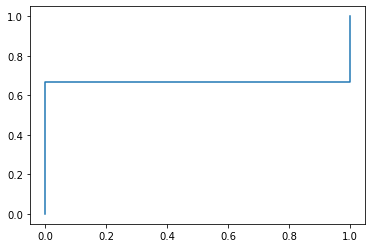

In [7]:
plt.plot(fpr, tpr)

In [8]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [9]:
# 'median_normalized_bioactive_like_rank': 0.02,
# 'fraction_top_bioactive_like': 0.31719532554257096,

In [10]:
for split in splits :

    for iteration in iterations :
        
        for dataset in datasets :
            
            experiment_name = f'{split}_split_{iteration}'
            evaluation_name = f'{experiment_name}_{dataset}'
            
            working_dir = os.path.join(results_dir, evaluation_name)
            for task in tasks :
                task_dir = os.path.join(working_dir, task)
                dataset_results_path = os.path.join(task_dir, f'dataset_results.p')
                with open(dataset_results_path, 'rb') as f:
                    dataset_results = pickle.load(f)

                for ranker in ['model', 'energy', 'random'] :
                    dataset_results['bioactive_accuracy'][ranker]['split'] = split
                    dataset_results['bioactive_accuracy'][ranker]['dataset'] = dataset
                    dataset_results['bioactive_accuracy'][ranker]['task'] = task
                    dataset_results['bioactive_accuracy'][ranker]['ranker'] = ranker
                    bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy'][ranker]), ignore_index=True)

                for average_type in dataset_results['regression'] :
                    dataset_results['regression'][average_type]['split'] = split
                    dataset_results['regression'][average_type]['dataset'] = dataset
                    dataset_results['regression'][average_type]['task'] = task
                    dataset_results['regression'][average_type]['average_type'] = average_type
                    regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                for ranker in dataset_results['ranking'] :
                    dataset_results['ranking'][ranker]['split'] = split
                    dataset_results['ranking'][ranker]['dataset'] = dataset
                    dataset_results['ranking'][ranker]['task'] = task
                    dataset_results['ranking'][ranker]['ranker'] = ranker
                    ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [11]:
correct_dataset_name = {
    'pdbbind' : 'PDBBind',
    'platinum' : 'Platinum'
}

# Regression

In [12]:
regression_df['subset'] = regression_df['task']

In [13]:
regression_df.head()

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.720300,0.722652,0.504923,0.504697,0.666996,1.199216,0.650523,0.700601,0.700295,random,all,all
1,Macro,pdbbind,0.349680,0.309036,-0.729639,-2.224724,0.578690,1.234634,0.550233,0.313516,0.288392,random,all,all
2,Micro,pdbbind,0.500544,0.486104,0.231128,0.215302,0.817321,0.871589,0.806741,0.572105,0.566154,random,easy,easy
3,Macro,pdbbind,0.306149,0.237231,-1.290880,-5.600067,0.530358,0.891179,0.477260,0.283958,0.225837,random,easy,easy
4,Micro,pdbbind,0.720809,0.725687,0.502103,0.505792,0.648171,1.362514,0.631612,0.683892,0.685014,random,hard,hard


In [14]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [15]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['dataset'] == dataset) 
                         & (regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'all')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

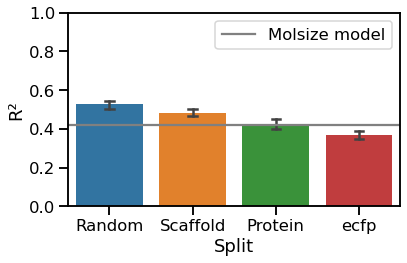

In [16]:
with sns.plotting_context('talk') :
    merged_data['Split'] = merged_data['split'].replace({'random' : 'Random',
                                            'scaffold' : 'Scaffold',
                                            'protein' : 'Protein'})
    sns.barplot(data=merged_data[merged_data['Conformation subset'] == 'All'] ,
                x='Split', y='R2', capsize=.1, errwidth=2.5)
    plt.axhline(y=0.42, color='grey', linestyle='-', label='Molsize model')
    plt.ylim(0, 1)
    plt.ylabel('R²')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/R2_barplot.png', dpi=300)

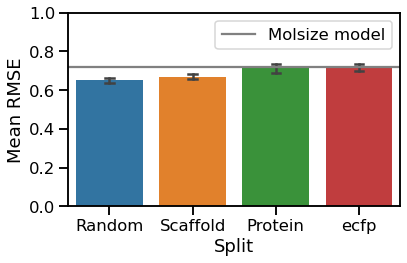

In [17]:
with sns.plotting_context('talk') :
    merged_data['Split'] = merged_data['split'].replace({'random' : 'Random',
                                            'scaffold' : 'Scaffold',
                                            'protein' : 'Protein'})
    sns.barplot(data=merged_data[merged_data['Conformation subset'] == 'All'] ,
                x='Split', y='Mean RMSE', capsize=.1, errwidth=2.5)
    plt.axhline(y=0.72, color='grey', linestyle='-', label='Molsize model')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/RMSE_barplot.png', dpi=300)

In [18]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random               0.65 ± 0.02  0.53 ± 0.03  1.17 ± 0.03  NA  0.63 ± 0.02   
Scaffold             0.67 ± 0.01  0.48 ± 0.02  1.23 ± 0.03  NA  0.65 ± 0.02   
Protein              0.71 ± 0.03  0.43 ± 0.04   1.3 ± 0.06  NA   0.7 ± 0.03   
Ecfp                 0.72 ± 0.02  0.37 ± 0.03  1.27 ± 0.03  NA   0.7 ± 0.02   

Conformation subset               
                              R2  
Split                             
Random               0.53 ± 0.03  
Scaffold             0.48 ± 0.02  
Protein              0.43 ± 0.04  
Ecfp                 0.36 ± 0.03

In [19]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['dataset'] == dataset) 
                         & (regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'hard')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

In [20]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random               0.65 ± 0.01  0.51 ± 0.02  1.32 ± 0.04  NA  0.63 ± 0.01   
Scaffold             0.67 ± 0.01  0.46 ± 0.02  1.39 ± 0.02  NA  0.66 ± 0.01   
Protein              0.73 ± 0.03  0.39 ± 0.04  1.54 ± 0.08  NA  0.71 ± 0.03   
Ecfp                 0.73 ± 0.02  0.32 ± 0.03  1.48 ± 0.04  NA  0.71 ± 0.02   

Conformation subset               
                              R2  
Split                             
Random               0.51 ± 0.02  
Scaffold             0.47 ± 0.02  
Protein               0.4 ± 0.05  
Ecfp                 0.32 ± 0.03

# Bioactive conformation identification

In [21]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [22]:
bioactive_accuracy_df['ranker'] = bioactive_accuracy_df['ranker'].replace({'model' : 'BioSchNet',
                                                                          'energy' : 'UFF energy',
                                                                          'random' : 'Random'})

In [23]:
bioactive_accuracy_df.head()

,dataset,mean_top1_accuracy,median_all_bioactive,median_min_bioactive,median_normalized_bioactive,q1_all_bioactive,q1_min_bioactive,q1_normalized_bioactive,q3_all_bioactive,q3_min_bioactive,q3_normalized_bioactive,ranker,split,task,subset
0,pdbbind,0.330244,4.0,3.0,0.074074,0.0,0.0,0.000000,20.00,19.0,0.340936,BioSchNet,random,all,all
1,pdbbind,0.165965,28.0,27.0,0.448980,3.0,3.0,0.099010,79.25,78.0,0.857143,UFF energy,random,all,all
2,pdbbind,0.050548,33.0,32.0,0.445545,9.0,8.0,0.226540,67.00,65.0,0.702970,Random,random,all,all
3,pdbbind,0.324930,3.0,2.0,0.142857,1.0,0.0,0.000000,9.00,7.0,0.416667,BioSchNet,random,easy,easy
4,pdbbind,0.249300,5.0,4.0,0.333333,1.0,1.0,0.015152,16.00,12.0,0.727273,UFF energy,random,easy,easy


In [24]:
ratiolabel = 'Fraction of molecules with bioactive ranked first'
ranklabel = 'Median normalized rank of bioactive conformation'
new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                         & (bioactive_accuracy_df['task'] == 'all')]
new_data = new_data.rename({'mean_top1_accuracy' : ratiolabel,
                           'median_normalized_bioactive' : ranklabel}, axis=1)

# new_data.sort_values('ranker', key=)

grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [25]:
grouped_data

Fraction of molecules with bioactive ranked first               \
Ranker                                           BioSchNet   UFF energy   
Split                                                                     
Random                                         0.32 ± 0.01  0.18 ± 0.01   
Scaffold                                       0.29 ± 0.02  0.18 ± 0.01   
Protein                                        0.21 ± 0.02  0.16 ± 0.01   
Ecfp                                           0.24 ± 0.02  0.18 ± 0.01   

                      Median normalized rank of bioactive conformation  \
Ranker         Random                                        BioSchNet   
Split                                                                    
Random    0.04 ± 0.01                                      0.08 ± 0.01   
Scaffold   0.04 ± 0.0                                       0.1 ± 0.02   
Protein   0.04 ± 0.01                                       0.2 ± 0.04   
Ecfp      0.04 ± 0.01                                      0.16 ± 0.02   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.43 ± 0.03  0.46 ± 0.01  
Scaffold  0.42 ± 0.01  0.47 ± 0.02  
Protein   0.48 ± 0.05  0.45 ± 0.01  
Ecfp      0.42 ± 0.02  0.44 ± 0.02

In [26]:
ratiolabel = 'Fraction of molecules with bioactive ranked first'
ranklabel = 'Median normalized rank of bioactive conformation'
new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                         & (bioactive_accuracy_df['task'] == 'hard')]
new_data = new_data.rename({'mean_top1_accuracy' : ratiolabel,
                           'median_normalized_bioactive' : ranklabel}, axis=1)

grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [27]:
grouped_data

Fraction of molecules with bioactive ranked first               \
Ranker                                           BioSchNet   UFF energy   
Split                                                                     
Random                                         0.33 ± 0.02  0.15 ± 0.01   
Scaffold                                        0.3 ± 0.02  0.15 ± 0.01   
Protein                                         0.2 ± 0.02  0.14 ± 0.02   
Ecfp                                           0.22 ± 0.02  0.15 ± 0.01   

                     Median normalized rank of bioactive conformation  \
Ranker        Random                                        BioSchNet   
Split                                                                   
Random    0.01 ± 0.0                                      0.06 ± 0.01   
Scaffold  0.01 ± 0.0                                      0.08 ± 0.02   
Protein   0.01 ± 0.0                                      0.18 ± 0.03   
Ecfp      0.01 ± 0.0                                      0.13 ± 0.03   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.48 ± 0.03  0.47 ± 0.02  
Scaffold  0.47 ± 0.04  0.48 ± 0.02  
Protein   0.52 ± 0.06  0.46 ± 0.01  
Ecfp      0.45 ± 0.01  0.47 ± 0.01

# Ranking

In [28]:
ranking_df['subset'] = ranking_df['task']

In [29]:
ranking_df.head()

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,normalized_ef_0.95,normalized_ef_0.96,normalized_ef_0.97,normalized_ef_0.98,normalized_ef_0.99,normalized_ef_1.0,ranker,split,task,subset
0,0.343955,pdbbind,1.091665,1.090624,1.043133,1.060931,1.084705,1.043887,1.017952,1.027163,...,0.316860,0.317041,0.317243,0.317222,0.316961,0.316939,random,random,all,all
1,0.367255,pdbbind,1.461757,1.273368,1.237081,1.294155,1.251645,1.242184,1.207332,1.196175,...,0.318265,0.317925,0.317671,0.317462,0.317187,0.316939,energy,random,all,all
2,0.382239,pdbbind,1.255373,1.314723,1.305135,1.244181,1.256137,1.211813,1.191778,1.198702,...,0.318152,0.317749,0.317696,0.317475,0.317187,0.316939,ccdc,random,all,all
3,0.481190,pdbbind,2.966612,2.907078,2.711104,2.568515,2.490489,2.423024,2.217528,2.219664,...,0.320843,0.320044,0.319092,0.318325,0.317574,0.316939,model,random,all,all
4,0.640132,pdbbind,1.143455,1.126993,1.105184,1.073711,1.053730,1.018521,1.011464,1.036855,...,0.604278,0.604099,0.604021,0.603941,0.603614,0.603614,random,random,easy,easy


In [30]:
def custom_ranker_order(series) :
    d = {'BioSchNet' : 0,
         'CCDC' : 1,
         'UFF energy' : 2,
         'Random' : 3}
    return [d[s] for s in series]

In [31]:
ratiolabel = 'Fraction of molecules with bioactive-like ranked first'
ranklabel = 'Median normalized rank of first bioactive-like conformation'
new_data = ranking_df[(ranking_df['dataset'] == dataset) 
                         & (ranking_df['task'] == 'all')]
new_data = new_data.rename({'fraction_top_bioactive_like' : ratiolabel,
                           'median_normalized_bioactive_like_rank' : ranklabel}, axis=1)

new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})

new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')
grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [32]:
grouped_data

Fraction of molecules with bioactive-like ranked first               \
Ranker                                                    model         ccdc   
Split                                                                          
Random                                          0.45 ± 0.01      0.39 ± 0.01   
Scaffold                                        0.42 ± 0.02      0.38 ± 0.03   
Protein                                         0.44 ± 0.03      0.41 ± 0.02   
Ecfp                                            0.41 ± 0.01      0.37 ± 0.02   

                                    \
Ranker         energy       random   
Split                                
Random    0.37 ± 0.01   0.3 ± 0.02   
Scaffold  0.35 ± 0.02   0.3 ± 0.03   
Protein    0.4 ± 0.02  0.34 ± 0.03   
Ecfp      0.36 ± 0.02  0.31 ± 0.02   

         Median normalized rank of first bioactive-like conformation  \
Ranker                                                         model   
Split                                                                  
Random                                           0.01 ± 0.0            
Scaffold                                        0.02 ± 0.01            
Protein                                          0.01 ± 0.0            
Ecfp                                             0.02 ± 0.0            

                                                
Ranker          ccdc       energy       random  
Split                                           
Random    0.02 ± 0.0   0.03 ± 0.0  0.03 ± 0.01  
Scaffold  0.02 ± 0.0  0.03 ± 0.01  0.04 ± 0.01  
Protein   0.02 ± 0.0   0.02 ± 0.0   0.03 ± 0.0  
Ecfp      0.03 ± 0.0   0.03 ± 0.0   0.04 ± 0.0

In [33]:
def custom_split_order(series) :
    d = {'Random' : 0,
         'Scaffold' : 1,
         'Protein' : 2}
    return [d[s] for s in series]

In [34]:
ylabel = 'Mean EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [35]:
grouped_data

Mean EF at fraction = 0.1                                       
Ranker                   BioSchNet         CCDC   UFF energy       Random
Split                                                                    
Random                  2.1 ± 0.04  1.18 ± 0.02  1.28 ± 0.05  1.02 ± 0.03
Scaffold               1.99 ± 0.05  1.21 ± 0.05  1.29 ± 0.06  0.99 ± 0.04
Protein                1.63 ± 0.08  1.21 ± 0.06  1.27 ± 0.05  1.02 ± 0.04
Ecfp                   1.67 ± 0.06  1.14 ± 0.05  1.23 ± 0.06  1.02 ± 0.02

In [36]:
ylabel = 'Mean EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'hard')]
new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [37]:
grouped_data

Mean EF at fraction = 0.1                                       
Ranker                   BioSchNet         CCDC   UFF energy       Random
Split                                                                    
Random                 2.53 ± 0.09  1.18 ± 0.03  1.36 ± 0.06  1.04 ± 0.01
Scaffold                2.35 ± 0.1  1.22 ± 0.08  1.36 ± 0.07  0.97 ± 0.03
Protein                1.87 ± 0.11  1.23 ± 0.08  1.35 ± 0.08  1.03 ± 0.07
Ecfp                    1.93 ± 0.1  1.14 ± 0.07  1.28 ± 0.08  1.04 ± 0.04

In [38]:
ylabel = 'Mean normalized EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'normalized_ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [39]:
grouped_data

Mean normalized EF at fraction = 0.1                            \
Ranker                              BioSchNet         CCDC   UFF energy   
Split                                                                     
Random                            0.42 ± 0.01  0.36 ± 0.01  0.35 ± 0.01   
Scaffold                           0.4 ± 0.03  0.35 ± 0.02  0.33 ± 0.03   
Protein                           0.43 ± 0.02  0.39 ± 0.03  0.38 ± 0.02   
Ecfp                              0.39 ± 0.01  0.35 ± 0.01  0.35 ± 0.01   

                       
Ranker         Random  
Split                  
Random     0.3 ± 0.02  
Scaffold  0.29 ± 0.02  
Protein   0.34 ± 0.02  
Ecfp      0.31 ± 0.01

In [40]:
ranker_name_to_clean = {'random' : 'Random',
                                     'energy' : 'UFF energy',
                                     'ccdc' : 'CCDC',
                                     'model_random' : 'BioSchNet (random split)',
                                     'model_scaffold' : 'BioSchNet (scaffold split)',
                                     'model_protein' : 'BioSchNet (protein split)'}

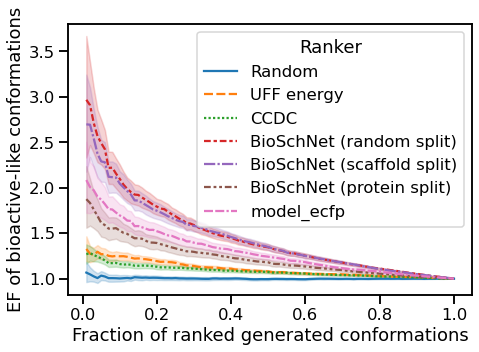

In [41]:
dataset = 'pdbbind'
task = 'all'
df = pd.DataFrame()
xlabel = 'Fraction of ranked generated conformations'
ylabel = 'EF of bioactive-like conformations'
for split in splits :
    evaluation_name = f'{split}_split_0_{dataset}'
    ef_df_path = os.path.join('results/',
                              evaluation_name,
                              task,
                              'ef_df.csv')
    ef_df = pd.read_csv(ef_df_path, index_col=0)
    ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
    ef_df = ef_df.rename({'Fraction' : xlabel,
                          'Enrichment factor' : ylabel}, axis=1)
    df = df.append(ef_df, ignore_index=True)

df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=df, x=xlabel, y=ylabel, hue='Ranker', style='Ranker')
    #plt.title(f'Generated conformation ranking evaluation ({dataset})')
    plt.xlabel('Fraction of ranked generated conformations')
    fig_path = os.path.join('figures/', 
                            f'efs_{dataset}.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

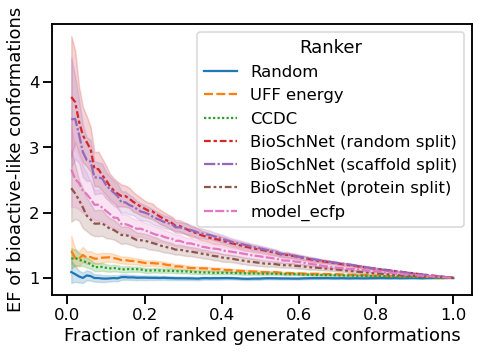

In [42]:
dataset = 'pdbbind'
task = 'hard'
df = pd.DataFrame()
xlabel = 'Fraction of ranked generated conformations'
ylabel = 'EF of bioactive-like conformations'
for split in splits :
    evaluation_name = f'{split}_split_0_{dataset}'
    ef_df_path = os.path.join('results/',
                              evaluation_name,
                              task,
                              'ef_df.csv')
    ef_df = pd.read_csv(ef_df_path, index_col=0)
    ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
    ef_df = ef_df.rename({'Fraction' : xlabel,
                          'Enrichment factor' : ylabel}, axis=1)
    df = df.append(ef_df, ignore_index=True)

df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=df, x=xlabel, y=ylabel, hue='Ranker', style='Ranker')
    #plt.title(f'Generated conformation ranking evaluation ({dataset})')
    plt.xlabel('Fraction of ranked generated conformations')
    fig_path = os.path.join('figures/', 
                            f'efs_{dataset}.png')
    plt.tight_layout()
    #plt.savefig(fig_path, dpi=300)
    plt.show()

# Rigid ligand docking

In [43]:
ranker_name_to_clean['score'] = 'PLP score'

In [44]:
def custom_ranker_order(series) :
    ranked_list = ['Random', 'UFF energy', 'CCDC',
                   'BioSchNet (random split)',
                   'BioSchNet (scaffold split)',
                   'BioSchNet (protein split)',
                   'PLP score']
    d = {ranker : i 
         for i, ranker in enumerate(ranked_list)}
    return [d[s] for s in series]

In [45]:
def get_title(metric) :
    if metric == 'first_successful_pose' :
        title = 'Successful docking'
    elif metric == 'ligand_rmsd' :
        title = 'Retrieval of best pose (among successful docking)'
    else :
        title = f'Retrieval of top {metric}'
    return title

In [46]:
flexible_docking_powers = {
    'random' : 0.79,
    'scaffold' : 0.77,
    'protein' : 0.71
}

flexible_generation_powers = {
    'random' : 0.84,
    'scaffold' : 0.83,
    'protein' : 0.84
}

In [47]:
splits = ['random', 'scaffold', 'protein']
df = pd.DataFrame()
for split in splits :
    for iteration in range(5) :
        evaluation_name = f'{split}_split_{iteration}_pdbbind'
        recall_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'rigid_ligand_docking_recall_all.csv')
        recall_df = pd.read_csv(recall_df_path, index_col=0)
        recall_df['Number of input conformations'] = recall_df['Number of input conformations'] + 1
        recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
        recall_df['baseline'] = split
        recall_df['iteration'] = iteration
        flexible_docking_power = flexible_docking_powers[split]
#         print(recall_df[(recall_df['Recall'] >= flexible_docking_power) 
#                   & (recall_df['metric'] == 'first_successful_pose')].drop_duplicates(subset='ranker')[['Number of input conformations', 'ranker']])
        df = df.append(recall_df, ignore_index=True)
df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)

In [48]:
df[(df['Number of input conformations'] == 100) & (df['metric'] == 'first_successful_pose')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

Recall          
                    mean       std
ranker                            
CCDC            0.834036  0.015601
energy          0.834036  0.015601
model_protein   0.830245  0.019130
model_random    0.825830  0.006585
model_scaffold  0.846033  0.012670
random          0.834036  0.015601
score           0.834036  0.015601

In [49]:
# Docking power 75%
n_docking_power = df[(df['Recall'] >= 0.75) & (df['metric'] == 'first_successful_pose')].drop_duplicates(subset=['Ranker', 'baseline', 'iteration'])# .groupby('ranker').agg({'Conformation rank' : ['mean', 'std']})

In [50]:
n_docking_power.groupby('Ranker').agg(['mean', 'std'])

Number of input conformations              Recall  \
                                                    mean       std      mean   
Ranker                                                                         
BioSchNet (protein split)                      39.600000  5.983310  0.751453   
BioSchNet (random split)                       25.400000  1.673320  0.751885   
BioSchNet (scaffold split)                     27.000000  5.787918  0.752056   
CCDC                                           38.600000  6.021390  0.751115   
PLP score                                      15.000000  5.014265  0.752567   
Random                                         33.800000  5.267149  0.753324   
UFF energy                                     44.533333  6.895823  0.751745   

                                     iteration            
                                 std      mean       std  
Ranker                                                    
BioSchNet (protein split)   0.001585         2  1.581139  
BioSchNet (random split)    0.002109         2  1.581139  
BioSchNet (scaffold split)  0.001945         2  1.581139  
CCDC                        0.000931         2  1.463850  
PLP score                   0.002213         2  1.463850  
Random                      0.002345         2  1.463850  
UFF energy                  0.001542         2  1.463850

In [51]:
df = df.sort_values(by='Ranker', key=custom_ranker_order)

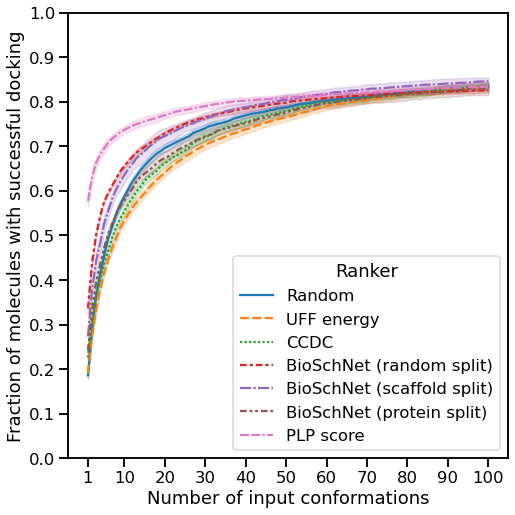

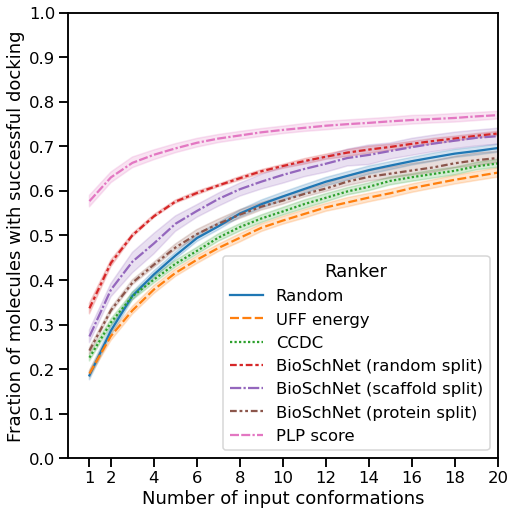

In [52]:
metric = 'first_successful_pose'

metric_df = df[df['metric'] == metric]
#metric_df = metric_df[metric_df['Ranker'] !='PLP score']

# title = get_title(metric)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7.5, 7.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y='Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of molecules with successful docking')
    plt.ylim(0, 1)
    plt.xticks([1] + list(range(10, 101, 10)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

    plt.figure(figsize=(7.5, 7.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y='Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of molecules with successful docking')
    plt.xlim(0, 20)
    plt.ylim(0, 1)
    plt.xticks([1] + list(range(2, 21, 2)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking_truncated.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()
    plt.close()

In [53]:
df = pd.DataFrame()
for split in splits :
    for iteration in range(5) :
        evaluation_name = f'{split}_split_{iteration}_pdbbind'
        recall_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'rigid_ligand_docking_recall_successful_only.csv')
        recall_df = pd.read_csv(recall_df_path, index_col=0)
        recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
        recall_df['iteration'] = iteration
        df = df.append(recall_df, ignore_index=True)
df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
df = df.sort_values(by='Ranker', key=custom_ranker_order)

In [54]:
df['Number of input conformations'] = df['Number of input conformations'] + 1

In [55]:
df[(df['Number of input conformations'] == 20) & (df['metric'] == 'ligand_rmsd')].groupby('Ranker', sort=False).agg({'Recall' : ['mean', 'std']})

Recall          
                                mean       std
Ranker                                        
Random                      0.208554  0.021047
UFF energy                  0.308676  0.018451
CCDC                        0.184624  0.013748
BioSchNet (random split)    0.525572  0.031230
BioSchNet (scaffold split)  0.412372  0.032318
BioSchNet (protein split)   0.348432  0.028596
PLP score                   0.781763  0.037660

In [56]:
df['metric'].unique()

array(['first_successful_pose', 'score', 'overlay_rmsd', 'ligand_rmsd',
       'correct_conf'], dtype=object)

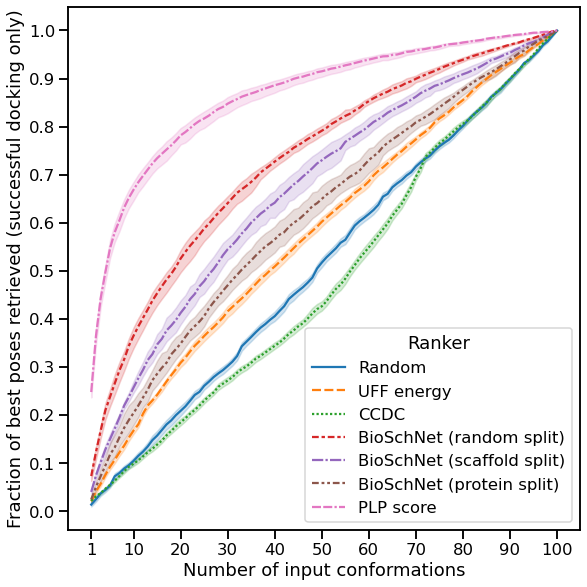

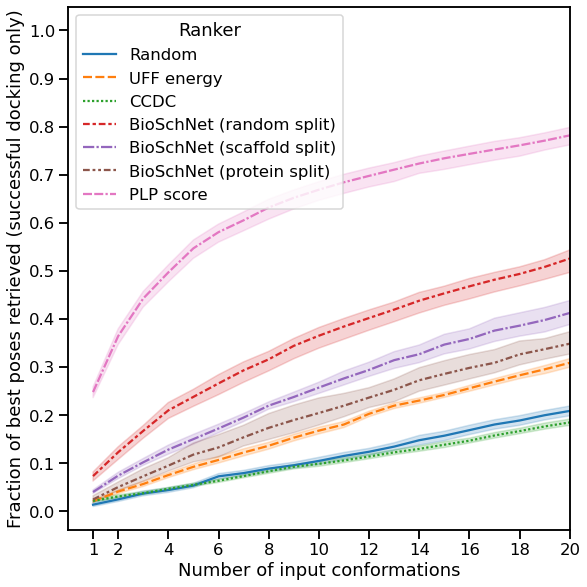

In [57]:
metric = 'ligand_rmsd'

metric_df = df[df['metric'] == metric]
#metric_df = metric_df[metric_df['Ranker'] !='PLP score']

title = get_title(metric)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(8.5, 8.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y=f'Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of best poses retrieved (successful docking only)')
    plt.xticks([1] + list(range(10, 101, 10)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking.png')
    #plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

    plt.figure(figsize=(8.5, 8.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y=f'Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of best poses retrieved (successful docking only)')
    plt.xlim(0, 20)
    plt.xticks([1] + list(range(2, 21, 2)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking_truncated.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()
    plt.close()